In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import contextlib
from ler.rates import LeR
from gwsnr import GWSNR
from ler.utils import append_json, get_param_from_json

Setting multiprocessing start method to 'fork'


In [2]:
class TrainingDataGenerator():

    def __init__(self,
        npool=4,
        z_min=0.0,
        z_max=5.0,
        verbose=True,
        output_jsonfile="L1H1V1_IMRPhenomXPHM.json",
        **kwargs,  # ler and gwsnr arguments
    ):

        self.npool = npool
        self.z_min = z_min
        self.z_max = z_max
        self.verbose = verbose

        self.ler_init_args = dict(
            event_type="BBH",
            cosmology=None,
            ler_directory="./ler_data",
            # gwsnr args
            mtot_min=2.0,
            mtot_max=200,
            ratio_min=0.1,
            ratio_max=1.0,
            mtot_resolution=500,
            ratio_resolution=50,
            sampling_frequency=2048.0,
            waveform_approximant="IMRPhenomXPHM",
            minimum_frequency=20.0,
            snr_type="inner_product",
            psds=None,
            ifos=None,
            interpolator_dir="./interpolator_pickle",
            create_new_interpolator=False,
            gwsnr_verbose=False,
            multiprocessing_verbose=True,
            mtot_cut=True,
        )
        self.ler_init_args.update(kwargs)

        self.json_path = f"{self.ler_init_args['ler_directory']}/{output_jsonfile}"

        # recalculate snr within the snr_range.
        # find snr in astrophysical range
        # save it

    def snr_recalculation(self):
        
        args = self.ler_init_args.copy()

        # gwsnr initialization
        gwsnr = GWSNR(
            npool=self.npool,
            mtot_min=args['mtot_min'],
            mtot_max=args['mtot_max'],
            ratio_min=args['ratio_min'],
            ratio_max=args['ratio_max'],
            mtot_resolution=args['mtot_resolution'],
            ratio_resolution=args['ratio_resolution'],
            sampling_frequency=args['sampling_frequency'],
            waveform_approximant=args['waveform_approximant'],
            minimum_frequency=args['minimum_frequency'],
            snr_type='inner_product', 
            psds=args['psds'],
            ifos=args['ifos'],
            interpolator_dir=args['interpolator_dir'],
            create_new_interpolator=args['create_new_interpolator'],
            gwsnr_verbose=args['gwsnr_verbose'],
            multiprocessing_verbose=args['multiprocessing_verbose'],
            mtot_cut=args['mtot_cut'],
        )

        # get the spinless snr
        print(f'getting the GW parameters with spinless snr from {self.json_path}')
        unlensed_params = get_param_from_json(self.json_path)
        print('Recalculating SNRs using inner_product method')
        snrs = gwsnr.snr(gw_param_dict=unlensed_params)
        unlensed_params.update(snrs)

        # save the parameters
        append_json(self.json_path, unlensed_params, replace=True);
        print(f"json file saved at: {self.json_path}\n")

    def gw_parameters_generator(self, size, batch_size, spinless=True,trim_to_size=False, verbose=True, replace=False, data_distribution_range = [0, 2, 4, 6, 8, 10, 12, 14, 16, 100]):

        args = self.ler_init_args.copy()

        # ler initialization
        ler = LeR(
            npool=self.npool,
            z_min=self.z_min,
            z_max=self.z_max,  # becareful with this value
            verbose=self.verbose,
            spin_zero=False,
            spin_precession=True,
            # ler
            event_type=args['event_type'],
            cosmology=args['cosmology'],
            ler_directory=args['ler_directory'],
            # gwsnr args
            mtot_min=args['mtot_min'],
            mtot_max=args['mtot_max'],
            ratio_min=args['ratio_min'],
            ratio_max=args['ratio_max'],
            mtot_resolution=args['mtot_resolution'],
            ratio_resolution=args['ratio_resolution'],
            sampling_frequency=args['sampling_frequency'],
            waveform_approximant=args['waveform_approximant'],
            minimum_frequency=args['minimum_frequency'],
            snr_type='interpolation',
            psds=args['psds'],
            ifos=args['ifos'],
            interpolator_dir=args['interpolator_dir'],
            create_new_interpolator=args['create_new_interpolator'],
            gwsnr_verbose=args['gwsnr_verbose'],
            multiprocessing_verbose=args['multiprocessing_verbose'],
            mtot_cut=args['mtot_cut'],
        )
        ler.batch_size = batch_size

        gwsnr = GWSNR(
            npool=self.npool,
            mtot_min=args['mtot_min'],
            mtot_max=args['mtot_max'],
            ratio_min=args['ratio_min'],
            ratio_max=args['ratio_max'],
            mtot_resolution=args['mtot_resolution'],
            ratio_resolution=args['ratio_resolution'],
            sampling_frequency=args['sampling_frequency'],
            waveform_approximant=args['waveform_approximant'],
            minimum_frequency=args['minimum_frequency'],
            snr_type='inner_product', 
            psds=args['psds'],
            ifos=args['ifos'],
            interpolator_dir=args['interpolator_dir'],
            create_new_interpolator=args['create_new_interpolator'],
            gwsnr_verbose=args['gwsnr_verbose'],
            multiprocessing_verbose=args['multiprocessing_verbose'],
            mtot_cut=args['mtot_cut'],
        )

        # path to save parameters
        json_path = self.json_path
        if replace:
            if os.path.exists(json_path):
                os.remove(json_path)
            len_final = 0
        else:
            unlensed_param = get_param_from_json(json_path)
            len_final = len(unlensed_param['optimal_snr_net'])
            print(f'current size of the json file: {len_final}\n')

        print(f'total event to collect: {size}\n')
        while len_final<size:
            with contextlib.redirect_stdout(None):
                unlensed_param = ler.unlensed_cbc_statistics(size=ler.batch_size, resume=False)

            if data_distribution_range is not None:
                unlensed_param_ = self.helper_data_distribution(unlensed_param, data_distribution_range)
                #print(f'spinless snr :{unlensed_param_["optimal_snr_net"]}')  

                snrs = gwsnr.snr(gw_param_dict=unlensed_param_)
                unlensed_param_['optimal_snr_net'] = snrs['optimal_snr_net']
                #print(f'inner product snr :{unlensed_param_["optimal_snr_net"]}')

                unlensed_param = self.helper_data_distribution(unlensed_param_, data_distribution_range)
                #print(f'inner product snr resampled:{unlensed_param["optimal_snr_net"]}')

            # save the parameters
            append_json(json_path, unlensed_param, replace=False);

            # print(f"Collected number of events: {len_}")
            len_final += len(unlensed_param['optimal_snr_net'])
            if verbose:
                print(f"Collected number of events: {len_final}")

        if trim_to_size:
            unlensed_param = get_param_from_json(json_path)
            for key, value in unlensed_param.items():
                unlensed_param[key] = value[:size]
            append_json(json_path, unlensed_param, replace=True);
            len_final = len(unlensed_param['optimal_snr_net'])

        print(f"final size: {len_final}\n")
        print(f"json file saved at: {json_path}\n")

    def helper_data_distribution(self, unlensed_param, data_distribution_range):
    # optimal SNR 
        snr = np.array(unlensed_param['optimal_snr_net'])

        idx_arr = []
        snr_range = np.array(data_distribution_range)
        len_ = len(snr_range) 
        len_arr = []  # size of len_arr is len_-1  
        for j in range(len_-1):
            idx_ = np.argwhere((snr>=snr_range[j]) & (snr<snr_range[j+1])).flatten()
            idx_arr.append(idx_)
            len_arr.append(len(idx_))

        idx_arr = np.array(idx_arr, dtype=object)
        len_ref = min(len_arr)
        unlensed_param_final = {}

        for key, value in unlensed_param.items():
            for j, len_ in enumerate(len_arr):  # loop over snr range
                idx_buffer = np.random.choice(idx_arr[j], len_ref, replace=False)
                buffer_ = value[idx_buffer]

                if j==0:
                    unlensed_param_final[key] = buffer_
                else:
                    unlensed_param_final[key] = np.concatenate([unlensed_param_final[key], buffer_])

        return unlensed_param_final

    def combine_dicts(self, 
        path_list, 
        detector,
        parameter_list=['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'psi', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2'],
        output_jsonfile="combined_data.json",
    ):

        parameter_list += [detector]
        
        combined_dict = {}

        for path in path_list:
            data = get_param_from_json(path)
            for key, value in data.items():
                if key in parameter_list:
                    if key in combined_dict:
                        combined_dict[key] = np.concatenate([combined_dict[key], value])
                    else:
                        combined_dict[key] = value

        json_path = f"{self.ler_init_args['ler_directory']}/{output_jsonfile}"
        append_json(json_path, combined_dict, replace=True);

    def delete_json_file(self, path_list):
        for path in path_list:
            if os.path.exists(path):
                os.remove(path)

In [3]:
mg = TrainingDataGenerator(
    verbose=False, 
    ifos=['L1'], 
    output_jsonfile="L1_IMRPhenomXPHM_1.json",
)

In [5]:
size = 5
batch_size = 100000
spinless=True
trim_to_size=False
verbose=True
replace=False
data_distribution_range = [0, 2, 4, 6, 8, 10, 12, 14, 16, 100]

args = mg.ler_init_args.copy()

# ler initialization
ler = LeR(
    npool=mg.npool,
    z_min=mg.z_min,
    z_max=mg.z_max,  # becareful with this value
    verbose=mg.verbose,
    spin_zero=False,
    spin_precession=True,
    # ler
    event_type=args['event_type'],
    cosmology=args['cosmology'],
    ler_directory=args['ler_directory'],
    # gwsnr args
    mtot_min=args['mtot_min'],
    mtot_max=args['mtot_max'],
    ratio_min=args['ratio_min'],
    ratio_max=args['ratio_max'],
    mtot_resolution=args['mtot_resolution'],
    ratio_resolution=args['ratio_resolution'],
    sampling_frequency=args['sampling_frequency'],
    waveform_approximant=args['waveform_approximant'],
    minimum_frequency=args['minimum_frequency'],
    snr_type='interpolation',
    psds=args['psds'],
    ifos=args['ifos'],
    interpolator_dir=args['interpolator_dir'],
    create_new_interpolator=args['create_new_interpolator'],
    gwsnr_verbose=args['gwsnr_verbose'],
    multiprocessing_verbose=args['multiprocessing_verbose'],
    mtot_cut=args['mtot_cut'],
)
ler.batch_size = batch_size

In [7]:
json_path = mg.json_path
os.remove(json_path)

In [8]:
with contextlib.redirect_stdout(None):
    unlensed_param = ler.unlensed_cbc_statistics(size=ler.batch_size, resume=False)

In [11]:
np.array(unlensed_param['optimal_snr_net']), np.array(unlensed_param['L1'])

(array([1.15875597, 0.96751973, 0.73100406, ..., 1.05818217,
        0.18407855, 0.65020764]),
 array([1.15875597, 0.96751973, 0.73100406, ..., 1.05818217,
        0.18407855, 0.65020764]))

In [12]:
snr = np.array(unlensed_param['optimal_snr_net'])

idx_arr = []
snr_range = np.array(data_distribution_range)
len_ = len(snr_range) 
len_arr = []  # size of len_arr is len_-1  
for j in range(len_-1):
    idx_ = np.argwhere((snr>=snr_range[j]) & (snr<snr_range[j+1])).flatten()
    idx_arr.append(idx_)
    len_arr.append(len(idx_))
    
idx_arr = np.array(idx_arr, dtype=object)
len_ref = min(len_arr)

In [15]:
len_arr

[93718, 5247, 716, 180, 78, 24, 13, 12, 12]

In [16]:
unlensed_param_final = {}
for key, value in unlensed_param.items():
    for j, len_ in enumerate(len_arr):  # loop over snr range
        idx_buffer = np.random.choice(idx_arr[j], len_ref, replace=False)
        buffer_ = value[idx_buffer]

        if j==0:
            unlensed_param_final[key] = buffer_
        else:
            unlensed_param_final[key] = np.concatenate([unlensed_param_final[key], buffer_])

In [20]:
unlensed_param_final['optimal_snr_net'][:5]

array([0.55413689, 0.46795928, 1.74669297, 0.76307435,
       0.19183647])

In [25]:
snrs = ler.snr_bilby(gw_param_dict=unlensed_param_final)
snrs['optimal_snr_net'][:5]

100%|████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 294.11it/s]


array([0.39493652, 1.38641851, 0.22151475, 0.56420354,
       0.22221154])

In [28]:
unlensed_param_final_1 = unlensed_param_final.copy()
unlensed_param_final_1.update(snrs)
unlensed_param_final_1['optimal_snr_net'][:5]

array([0.39493652, 1.38641851, 0.22151475, 0.56420354,
       0.22221154])

In [ ]:
snr = np.array(unlensed_param_final_1['optimal_snr_net'])

idx_arr = []
snr_range = np.array(data_distribution_range)
len_ = len(snr_range) 
len_arr = []  # size of len_arr is len_-1  
for j in range(len_-1):
    idx_ = np.argwhere((snr>=snr_range[j]) & (snr<snr_range[j+1])).flatten()
    idx_arr.append(idx_)
    len_arr.append(len(idx_))
    
idx_arr = np.array(idx_arr, dtype=object)
len_ref = min(len_arr)

unlensed_param_final_2 = {}
# for key, value in unlensed_param_final_1.items():
#     for j, len_ in enumerate(len_arr):  # loop over snr range
#         idx_buffer = np.random.choice(idx_arr[j], len_ref, replace=False)
#         buffer_ = value[idx_buffer]

#         if j==0:
#             unlensed_param_final_2[key] = buffer_
#         else:
#             unlensed_param_final_2[key] = np.concatenate([unlensed_param_final_2[key], buffer_])

In [ ]:
for j, idx_arr_ in enumerate(idx_arr):
    idx_buffer = np.random.choice(idx_arr_, len_ref, replace=False)
    for key, value in unlensed_param_final_1.items():
        if j==0:
            unlensed_param_final_2[key] = value[idx_buffer]
        else:
            unlensed_param_final_2[key] = np.concatenate([unlensed_param_final_2[key], value[idx_buffer]])

In [33]:
unlensed_param_final_2['optimal_snr_net'][:5]

array([0.78906626, 1.98614363, 0.07591927, 0.22221154,
       3.23720039])

In [34]:
snrs_test = ler.snr_bilby(gw_param_dict=unlensed_param_final_2)
snrs_test['optimal_snr_net'][:5]

100%|██████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 152.63it/s]


array([1.91069509, 3.51437789, 0.71882275, 0.24882254,
       0.86881772])

In [28]:
mg = TrainingDataGenerator(
    verbose=False, 
    ifos=['L1'], 
    output_jsonfile="L1_IMRPhenomXPHM_1.json",
)
mg.gw_parameters_generator(size=5, batch_size=200000, spinless=True,trim_to_size=False, verbose=True, data_distribution_range = [0., 2., 4., 6., 8., 10., 12., 14., 16., 100.], replace=True)
# mg.snr_recalculation();

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
total event to collect: 5

solving SNR with inner product


100%|████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 341.80it/s]


Collected number of events: 9
final size: 9

json file saved at: ./ler_data/L1_IMRPhenomXPHM_1.json



In [29]:
test1 = get_param_from_json("ler_data/L1_IMRPhenomXPHM_1.json")
test1['L1']

array([ 4.9843872 ,  5.80797364, 16.58241323,  7.58600327,
       14.17423978,  5.60001593, 17.51488846,  8.99315381,
       10.86477994])

In [30]:
test1['optimal_snr_net']

array([ 0.96105075,  2.05824634,  5.60258136,  7.96500186,
        9.07968089, 11.77710788, 13.16624714, 15.77174165,
       63.99038263])

In [36]:
gwsnr = GWSNR(npool=6, ifos=['L1'], snr_type='inner_product', gwsnr_verbose=False, waveform_approximant='IMRPhenomXPHM')
test2 = gwsnr.snr(gw_param_dict=test1)
test2['optimal_snr_net']

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
solving SNR with inner product


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 44.23it/s]


array([ 1.38529498,  5.66772634, 14.3207243 ,  2.66654595,
       10.28865623, 11.77710788, 13.16624714,  7.03926581,
       21.64688701])

In [32]:
test2['L1']

array([ 1.38529498,  5.66772634, 14.3207243 ,  2.66654595,
       10.28865623, 11.77710788, 13.16624714,  7.03926581,
       21.64688701])

In [166]:
test1.keys(), test2.keys()

(dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'optimal_snr_net']),
 dict_keys(['L1', 'optimal_snr_net']))

In [156]:
test['L1']

array([ 1.24436489,  1.5831693 ,  2.45158835, ..., 23.60688699,
       24.48652324, 22.77524959])

In [159]:
test2 = get_param_from_json("ler_data/L1_IMRPhenomXPHM_1.json")

In [161]:
test2['L1']

array([ 2.75690654,  5.24783857,  3.90793817, ..., 26.11107896,
       39.67790435,  7.10242841])

In [158]:
mg = TrainingDataGenerator(
    npool=8,
    verbose=False, 
    ifos=['L1'], 
    output_jsonfile="L1_IMRPhenomXPHM_1.json",
)
mg.snr_recalculation();

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
getting the GW parameters with spinless snr from ./ler_data/L1_IMRPhenomXPHM_1.json
Recalculating SNRs using inner_product method
solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 807.62it/s]


json file saved at: ./ler_data/L1_IMRPhenomXPHM_1.json



In [144]:
mg = TrainingDataGenerator(
    verbose=False, 
    ifos=['L1','H1','V1'], 
    output_jsonfile="L1H1V1_IMRPhenomXPHM.json",
    data_distribution_range = [0., 2., 4., 6., 8., 10., 12., 14., 16., 100.],
    )
mg.gw_parameters_generator(size=1000, batch_size=10000,spinless=True,trim_to_size=False, verbose=False)
mg.snr_recalculation();

current size of the json file: 1026

total event to collect: 1000

final size: 1026

json file saved at: ./ler_data/L1H1V1_IMRPhenomXPHM.json

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
getting the GW parameters with spinless snr from ./ler_data/L1H1V1_IMRPhenomXPHM.json
Recalculating SNRs using inner_product method
solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 592.07it/s]


json file saved at: ./ler_data/L1H1V1_IMRPhenomXPHM.json



In [105]:
mg = TrainingDataGenerator(
    verbose=False, 
    ifos=['L1','H1','V1'], 
    output_jsonfile="L1H1V1_IMRPhenomXPHM_astro.json",
    data_distribution_range = None,
    )
mg.gw_parameters_generator(size=1000, batch_size=10000,spinless=True,trim_to_size=True)
mg.snr_recalculation();

total event to collect: 1000

Collected number of events: 10000
final size: 1000

json file saved at: ./ler_data/L1H1V1_IMRPhenomXPHM_astro.json

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
getting the GW parameters with spinless snr from ./ler_data/L1H1V1_IMRPhenomXPHM_astro.json
Recalculating SNRs using inner_product method
solving SNR with inner product


100%|████████████████████████████████████████████████████████████| 942/942 [00:01<00:00, 487.06it/s]

json file saved at: ./ler_data/L1H1V1_IMRPhenomXPHM_astro.json



In [145]:
mg.combine_dicts(
    path_list=[
        "ler_data/L1_IMRPhenomXPHM_1.json",
        "ler_data/L1_IMRPhenomXPHM_2.json",
        "ler_data/L1H1V1_IMRPhenomXPHM.json",
        "ler_data/L1H1V1_IMRPhenomXPHM_astro.json",
    ],
    detector='L1',
    output_jsonfile="L1H1V1_IMRPhenomXPHM_combined.json",
)

In [124]:
# 0, 2, 4, 6, 8, 10, 12, 14, 16, 100
print(np.sum((data['L1']>2)&(data['L1']<4)))
print(np.sum((data['L1']>14)&(data['L1']<16)))
print(np.sum((data['L1']>16)&(data['L1']<100)))

112
112
112


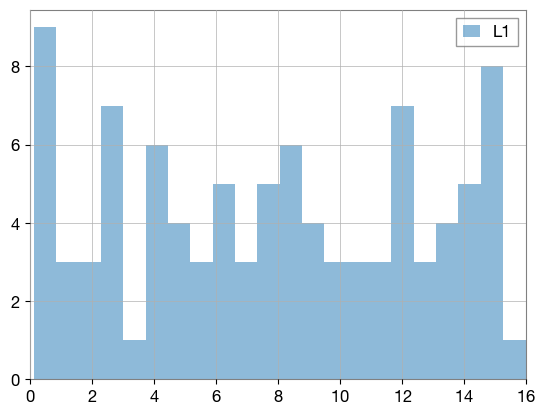

In [149]:
#data = get_param_from_json("ler_data/L1H1V1_IMRPhenomXPHM_combined.json")
data = get_param_from_json("ler_data/L1_IMRPhenomXPHM_2.json")

# plot 'L1' SNR
plt.hist(data['L1'], bins=50, alpha=0.5, label='L1')
plt.xlim(0, 16)
plt.legend()
plt.show()

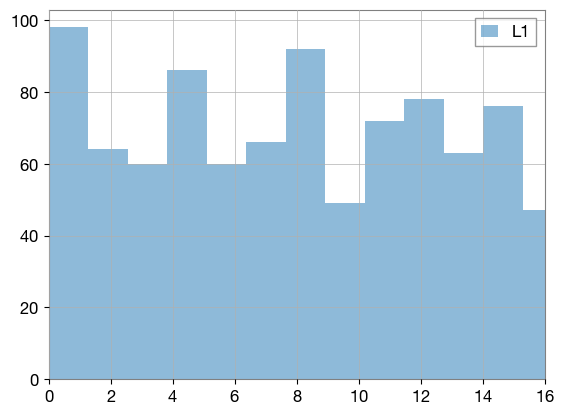

In [122]:
#data = get_param_from_json("ler_data/L1H1V1_IMRPhenomXPHM_combined.json")
data = get_param_from_json("ler_data/L1_IMRPhenomXPHM.json")

# plot 'L1' SNR
plt.hist(data['L1'], bins=50, alpha=0.5, label='L1')
plt.xlim(0, 16)
plt.legend()
plt.show()

In [ ]:
class ModelGenerator():

    def __init__(self,
        npool=4,
        size=1000,
        batch_size=200000,
        z_min=0.0,
        z_max=5.0,
        psds={'L1':'aLIGO_O4_high_asd.txt','H1':'aLIGO_O4_high_asd.txt', 'V1':'AdV_asd.txt', 'K1':'KAGRA_design_asd.txt'},
        verbose=True,
        create_new=True,
        data_distribution_range = dict(
            snr_range=[0, 2, 4, 6, 8, 10, 12, 14, 16, 100],
            reference_range = 16,
        ),
        extra_astrophysical_data = True,
        **kwargs,  # ler and gwsnr arguments
    ):

        self.npool = npool
        self.z_min = z_min
        self.z_max = z_max
        self.verbose = verbose
        self.data_distribution_range = data_distribution_range
        self.extra_astrophysical_data = extra_astrophysical_data

        self.ler_init_args = dict(
            event_type="BBH",
            cosmology=None,
            # gwsnr args
            mtot_min=2.0,
            mtot_max=200,
            ratio_min=0.1,
            ratio_max=1.0,
            mtot_resolution=500,
            ratio_resolution=50,
            sampling_frequency=2048.0,
            waveform_approximant="IMRPhenomXPHM",
            minimum_frequency=20.0,
            snr_type="inner_product",
            psds=None,
            ifos=None,
            interpolator_dir="./interpolator_pickle",
            create_new_interpolator=False,
            gwsnr_verbose=False,
            multiprocessing_verbose=True,
            mtot_cut=True,
        )
        self.ler_init_args.update(kwargs)

        if (self.ler_init_args['psds'] is None) & (self.ler_init_args['ifos'] is None):
            self.ler_init_args['ifos'] = ['L1', 'H1', 'V1']

        path_list = []
        self.detectors = detectors
        for det in detectors:
            path_list.append("ler_data/snr_"+det+"_spinless"+self.ler_init_args['waveform_approximant']+".json")
        self.path_list = path_list


        # use os to delete the exsiting file
        # to save snpinless snr first 
        if create_new:
            for i, det in enumerate(detectors):
                if os.path.exists(path_list[i]):
                    os.remove(path_list[i])

        # generate spinless snr for snr_range and astrophysical range
        self.spinless_waveform_snrs(size=size, batch_size=batch_size);

        # recalculate snr within the snr_range.
        # find snr in astrophysical range
        # save it

    def snr_recalculation(self):
        
        args = self.ler_init_args.copy()
        detectors = self.detectors

        for i, det in enumerate(detectors):

            if args['psds'] is not None:
                psds = args['psds'][det]
            else:
                psds = None
            if args['ifos'] is not None:
                ifos = args['ifos'][i]
            else:
                psds = None

            # gwsnr initialization
            gwsnr = GWSNR(
                npool=self.npool,
                mtot_min=args['mtot_min'],
                mtot_max=args['mtot_max'],
                ratio_min=args['ratio_min'],
                ratio_max=args['ratio_max'],
                mtot_resolution=args['mtot_resolution'],
                ratio_resolution=args['ratio_resolution'],
                sampling_frequency=args['sampling_frequency'],
                waveform_approximant=args['waveform_approximant'],
                minimum_frequency=args['minimum_frequency'],
                snr_type='inner_product', 
                psds=psds,
                ifos=ifos,
                interpolator_dir=args['interpolator_dir'],
                create_new_interpolator=args['create_new_interpolator'],
                gwsnr_verbose=args['gwsnr_verbose'],
                multiprocessing_verbose=args['multiprocessing_verbose'],
                mtot_cut=args['mtot_cut'],
            )

            # get the spinless snr
            unlensed_params = get_param_from_json(self.path_list[i])
            print('Recalculating SNRs using inner_product method')
            snrs = gwsnr.snr(gw_param_dict=unlensed_params)
            unlensed_params.update(snrs)

            # save the parameters
            append_json(path_list[i], unlensed_params, replace=True);


    def spinless_waveform_snrs(self, size, batch_size):

        args = self.ler_init_args.copy()
        detectors = self.detectors

        # ler initialization
        ler = LeR(
            npool=self.npool,
            z_min=self.z_min,
            z_max=self.z_max,  # becareful with this value
            verbose=self.verbose,
            spin_zero=False,
            spin_precession=True,
            # ler
            event_type=args['event_type'],
            cosmology=args['cosmology'],
            # gwsnr args
            mtot_min=args['mtot_min'],
            mtot_max=args['mtot_max'],
            ratio_min=args['ratio_min'],
            ratio_max=args['ratio_max'],
            mtot_resolution=args['mtot_resolution'],
            ratio_resolution=args['ratio_resolution'],
            sampling_frequency=args['sampling_frequency'],
            waveform_approximant=args['waveform_approximant'],
            minimum_frequency=args['minimum_frequency'],
            snr_type='interpolation', # inner_product
            psds=args['psds'],
            ifos=args['ifos'],
            interpolator_dir=args['interpolator_dir'],
            create_new_interpolator=args['create_new_interpolator'],
            gwsnr_verbose=args['gwsnr_verbose'],
            multiprocessing_verbose=args['multiprocessing_verbose'],
            mtot_cut=args['mtot_cut'],
        )

        ler.batch_size = batch_size

        # path for each detector
        path_list = self.path_list

        # check if the file exist and how many data points already there
        # print(f"Collected number of events: {len_}")
        for i, det in enumerate(detectors):
            if os.path.exists(path_list[i]):
                unlensed_params = get_param_from_json(path_list[i])
                len_final = len(unlensed_params[det])
                print(f"Already Collected number of events for {det}: {len_final}")
            else:
                len_final = 0

        # size = self.size
        print(f'total event to collect: {size}\n')
        while len_final<size:
            with contextlib.redirect_stdout(None):
                unlensed_param = ler.unlensed_cbc_statistics(size=ler.batch_size, resume=False)

            # SNR for each detector
            for i,det in enumerate(detectors):
                try:
                    snr = np.array(unlensed_param[det])
                except:
                    raise ValueError(f"Detector {det} is not available in the list of detectors. Check your input psds and ifos.")

                idx_arr = []
                snr_range = np.array(self.data_distribution_range['snr_range'])
                len_ = len(snr_range) 
                len_arr = []  # size of len_arr is len_-1  
                for j in range(len_-1):
                    idx_ = np.argwhere((snr>=j) & (snr<j+1)).flatten()
                    idx_arr.append(idx_)
                    len_arr.append(len(idx_))

                idx_arr = np.array(idx_arr, dtype=object)
                reference_range = self.data_distribution_range['reference_range']
                
                idx_ref = np.argwhere(snr_range==reference_range).flatten()
                len_ref = len_arr[idx_ref[0]]

                unlensed_param_final = {}

                for key, value in unlensed_param.items():
                    for j in range(len(len_arr)):
                        if len(idx_arr[j])>len_ref:

                            idx_buffer = np.random.choice(idx_arr[j], len_ref, replace=False)

                            # print(idx_buffer)
                            buffer_ = value[idx_buffer]
                        else:
                            buffer_ = value[idx_arr[j]]

                        if j==0:
                            unlensed_param_final[key] = buffer_
                        else:
                            unlensed_param_final[key] = np.concatenate([unlensed_param_final[key], buffer_])

                # save the parameters
                append_json(path_list[i], unlensed_param_final, replace=False);

            # print(f"Collected number of events: {len_}")
            for i, det in enumerate(detectors):
                unlensed_params = get_param_from_json(path_list[i])
                len_final = len(unlensed_params[det])
                print(f"Collected number of events for {det}: {len_final}")

            print(f"final size: {len_final}\n")

## ANNModelGenerator

In [ ]:
class ANNModelGenerator():
    def __init__(self,  parameters, detector, verbose=True):
        self.path_list = path_list
        self.detectors = detectors
        self.verbose = verbose